<a href="https://colab.research.google.com/github/saberrg/wec-simulation/blob/main/BEMStuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install capytaine
!pip install vtk
import capytaine as cpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.0 MB/s eta 0:00:00


In [ ]:
mesh = cpt.load_mesh('/content/buo.stl')

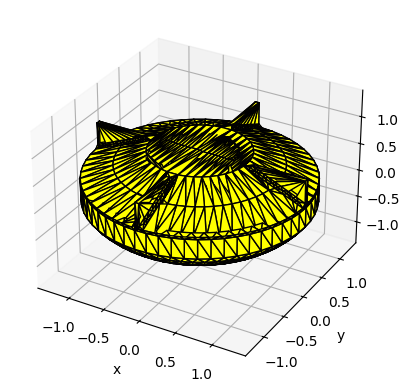

In [ ]:
#for fun to visualize the mesh
mesh.show_matplotlib()

**MAYBE NOT NEEDED**

In [ ]:
body = cpt.FloatingBody(mesh=mesh,
                        dofs=cpt.rigid_body_dofs(rotation_center=(0, 0, -2)),
                        center_of_mass=(0, 0, -2))

**THIS IS WHERE THE MAGIC HAPPENS ABOUT 1 MIN RUN TIME**

In [ ]:
import numpy as np
import capytaine as cpt

frequencies = np.linspace(0.45, 1.57, 10)
headings = [0.0, 90.0, 180.0]

radiation_problems = []
diffraction_problems = []

for freq in frequencies:
    for heading in headings:
        # 1) Radiation problems for each DOF:
        for dof_name in body.dofs:
            rad_problem = cpt.RadiationProblem(
                body=body,
                omega=freq,
                wave_direction=np.deg2rad(heading),
                radiating_dof=dof_name
            )
            radiation_problems.append(rad_problem)

        # 2) Diffraction problem for each (freq, heading) pair:
        diff_problem = cpt.DiffractionProblem(
            body=body,
            omega=freq,
            wave_direction=np.deg2rad(heading)
        )
        diffraction_problems.append(diff_problem)

all_problems = radiation_problems + diffraction_problems
solver = cpt.BEMSolver()
solutions = solver.solve_all(all_problems)

results = cpt.assemble_dataset(solutions)


**SAVING THE RESULTS**

In [ ]:
from capytaine.io.xarray import separate_complex_values
results_for_netcdf = separate_complex_values(results)

In [ ]:
results_for_netcdf.to_netcdf(
    "my_capytaine_output.nc",
    encoding={
        "radiating_dof": {"dtype": "U"},
        "influenced_dof": {"dtype": "U"}
    }
)

In [ ]:
import os
from capytaine.io.legacy import export_hydrostatics

os.makedirs("my_hydrostatics", exist_ok=True)
export_hydrostatics("my_hydrostatics", body)


[07:47:46] WARNING  Exporting problem in already existing directory: my_hydrostatics                               
                                 You might be overwriting existing files!

In [ ]:
#EXTRA
body.add_all_rigid_body_dofs()
hydrostatics = body.compute_hydrostatics(rho=1025.0)

In [ ]:

#V2 TEMPLATE SCRIPT THAT HAS EXTRA INFO (LIKE INTERTIA) RUN THIS TRIAL LATER
#IN WEC SIM TOO


import numpy as np
import xarray as xr
import capytaine as cpt
from capytaine.io.xarray import separate_complex_values

# --- 1a) Define your FloatingBody ---
mesh = cpt.load_mesh("buo.stl")
body = cpt.FloatingBody(mesh=mesh, name="myBuoy")
body.rotation_center = (0.0, 0.0, 0.0)
body.center_of_mass = (0, 0, -0.2)
body.add_all_rigid_body_dofs()
# Optional inertia/hydrostatics if not done earlier
body.inertia_matrix = body.compute_rigid_body_inertia()
body.hydrostatic_stiffness = body.immersed_part().compute_hydrostatic_stiffness()

# --- 1b) Define wave frequencies & headings ---
frequencies = np.linspace(0.45, 1.57, 10)  # rad/s example
headings = [0.0]

# --- 1c) Build radiation + diffraction problems ---
radiation_problems = []
diffraction_problems = []

for omega in frequencies:
    for heading in headings:
        # Radiation for each DOF
        for dof in body.dofs:
            rad_problem = cpt.RadiationProblem(
                body=body,
                omega=omega,
                wave_direction=np.deg2rad(heading),
                radiating_dof=dof
            )
            radiation_problems.append(rad_problem)

        # Diffraction
        diff_problem = cpt.DiffractionProblem(
            body=body,
            omega=omega,
            wave_direction=np.deg2rad(heading)
        )
        diffraction_problems.append(diff_problem)

# --- 1d) Solve all BEM problems + assemble results ---
all_problems = radiation_problems + diffraction_problems
solver = cpt.BEMSolver()
solutions = solver.solve_all(all_problems)
results = cpt.assemble_dataset(solutions)

# --- 1e) Export your BEM results to a netCDF file for BEMIO ---
# Capytaine uses complex arrays. We must separate them to store in netCDF properly.
from capytaine.io.xarray import separate_complex_values
results_for_netcdf = separate_complex_values(results)

# Also specify string encoding so xarray doesn't complain
results_for_netcdf.to_netcdf(
    "my_capytaine_output.nc",
    encoding={
        "radiating_dof": {"dtype": "U"},
        "influenced_dof": {"dtype": "U"}
    }
)


from capytaine.io.legacy import export_hydrostatics
import os

os.makedirs("my_hydrostatics", exist_ok=True)
export_hydrostatics("my_hydrostatics", body)



In [ ]:
print(results)


In [ ]:
!pip install capytaine vtk

import numpy as np
from math import pi
import capytaine as cpt
from capytaine.bem.airy_waves import airy_waves_free_surface_elevation
from capytaine.ui.vtk import Animation

cpt.set_logging("INFO")  # optional: see more solver details

bem_solver = cpt.BEMSolver()


def generate_buoy():
    """
    Load your buoy’s mesh and create a FloatingBody for it.
    Adjust rotation_center, center_of_mass, etc. as needed.
    """
    # Example if you have "buo.stl" in the same folder:
    buoy_mesh = cpt.load_mesh("buo.stl")
    buoy_mesh.vertices *= 2.0

    # Create a FloatingBody
    buoy = cpt.FloatingBody(
        mesh       = buoy_mesh,
        dofs       = cpt.rigid_body_dofs(rotation_center=(0, 0, 0)),
        center_of_mass = (0, 0, -0.2),  # your actual center_of_mass
        name       = "my_buoy"
    )
    # Optionally compute inertia
    buoy.inertia_matrix = buoy.compute_rigid_body_inertia()
    # Compute a linear hydrostatic stiffness
    buoy.hydrostatic_stiffness = buoy.immersed_part().compute_hydrostatic_stiffness()

    return buoy


def setup_animation(body, fs, omega, wave_amplitude, wave_direction):
    """
    Solve BEM problems (radiation + diffraction) at a single frequency
    then build an animation of the resulting RAO plus free-surface.
    """
    # 1) RADIATION: solve for each dof
    radiation_problems = []
    for dof in body.dofs:
        rad_prob = cpt.RadiationProblem(body=body, omega=omega,
                                        wave_direction=wave_direction,
                                        radiating_dof=dof)
        radiation_problems.append(rad_prob)

    radiation_results = bem_solver.solve_all(radiation_problems)

    # 2) DIFFRACTION:
    diff_problem = cpt.DiffractionProblem(
        body=body, omega=omega, wave_direction=wave_direction
    )
    diffraction_result = bem_solver.solve(diff_problem)

    # Assemble them for an RAO dataset
    dataset = cpt.assemble_dataset(radiation_results + [diffraction_result])
    # Post-process for RAO
    rao = cpt.post_pro.rao(dataset, wave_direction=wave_direction)

    # 3) Compute free-surface elevation
    # incoming wave
    incoming_waves_elev = airy_waves_free_surface_elevation(fs, diff_problem)

    # wave pattern from diffraction
    # (optional if you want to see the body-radiated waves)
    # radiation_elevation = bem_solver.compute_free_surface_elevation(
    #     fs, dataset, wave_amplitude, wave_direction, ...
    # )

    # 4) ANIMATION setup
    # The RAO gives motion amplitude & phase. We compute each mesh-face motion:
    # Suppose we pick the "dof" you want to animate.  Typically dof=...
    # but if there are multiple dofs, we can sum them.
    # For example: pick a single dof=2 => "heave" if that’s the second dof, etc.
    # or sum them all for total motion.  We'll do a naive "sum over all dofs":
    dof_list = body.dofs  # e.g. ["Heave", "Surge", ...]
    # sum RAO for each dof.  (If you only want pitch, do rao.sel(radiating_dof='Pitch'))
    rao_faces_motion = sum(
    rao.sel(omega=omega, radiating_dof=dof).data * body.dofs[dof]
    for dof in body.dofs)




    # Create the VTK-based Animation
    # loop_duration => one or two wave cycles
    loop_duration = 8 * pi / omega  # two wave cycles
    animation = Animation(loop_duration=loop_duration)

    # add the mesh (the body) with RAO-based face motion
    animation.add_body(body, faces_motion=wave_amplitude * rao_faces_motion)


    # add free-surface
    animation.add_free_surface(fs, wave_amplitude * incoming_waves_elev)

    return animation


if __name__ == "__main__":
    # 1) Generate your buoy
    body = generate_buoy()

    # 2) Make a grid for wave visualization
    # domain from x=-80..80, y=-80..80 (just an example)
    fs = cpt.FreeSurface(x_range=(-80, 80), y_range=(-80, 80),
                         nx=60, ny=60)

    # 3) Setup the animation with your chosen frequency, wave amplitude, wave dir
    # e.g. wave amplitude=1.0, wave freq=1.5 rad/s, wave direction=0 rad
    anim = setup_animation(body, fs, omega=1.5, wave_amplitude=2.0, wave_direction=0.0)

    # 4) Run the animation (will show in a pop-up if local; in Colab you typically record + download)
    anim.run(
        camera_position=(70, 70, 100),  # put the camera somewhere above
        resolution=(800, 600)          # pixel resolution
    )

    # 5) Save it to an .ogv or .mp4 or .gif
    # OGV is the default
    anim.save('animated_buoyV2.ogv',
              camera_position=(70,70,100),
              resolution=(800,600))

    print("Animation saved as 'animated_buoy.ogv'")


[16:58:33] INFO     Loading tabulation from                                                                        
                    /root/.cache/capytaine/2.2.1/tabulation_float64_scaled_nemoh3_676_100.0_372_-251.0_1001.npz

[16:58:34] INFO     The rotation dof Roll has been initialized around the point: FloatingBody(...,                 
                    name="my_buoy").rotation_center = [0. 0. 0.]

           INFO     The rotation dof Pitch has been initialized around the point: FloatingBody(...,                
                    name="my_buoy").rotation_center = [0. 0. 0.]

           INFO     The rotation dof Yaw has been initialized around the point: FloatingBody(...,                  
                    name="my_buoy").rotation_center = [0. 0. 0.]

           INFO     New floating body: FloatingBody(mesh=Mesh(..., name="buo.stl"), lid_mesh=None, dofs={"Surge":  
                    ..., "Sway": ..., "Heave": ..., "Roll": ..., "Pitch": ..., "Yaw": ...}, center_of_mass=[ 0.    
                    0.  -0.2], name="my_buoy").

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

[16:58:35] WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

           WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

           WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

           WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

           WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

           WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

[16:58:36] INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

Output()

           INFO     Solve RadiationProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf,   
                    radiating_dof='Surge').

[16:58:38] INFO     Solve RadiationProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf,   
                    radiating_dof='Sway').

           INFO     Solve RadiationProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf,   
                    radiating_dof='Heave').

           INFO     Solve RadiationProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf,   
                    radiating_dof='Roll').

           INFO     Solve RadiationProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf,   
                    radiating_dof='Pitch').

           INFO     Solve RadiationProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf,   
                    radiating_dof='Yaw').

           WARNING  The mesh of the body FloatingBody(..., name="my_buoy") has 1013 panels above the free surface. 
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           INFO     Clipping my_buoy with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])

           INFO     Solve DiffractionProblem(body=FloatingBody(..., name="my_buoy"), omega=1.500, water_depth=inf, 
                    wave_direction=0.000).

[16:58:39] INFO     Compute RAO.

           INFO     Precompute motions of buo.stl before animation.

[16:58:41] INFO     Precompute motions of free_surface_4503_mesh before animation.

Animation saved as 'animated_buoy.ogv'


[15:39:33] WARNING  Exporting problem in already existing directory: my_hydrostatics                               
                                 You might be overwriting existing files!